# import

In [4]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical
# 导入顺序模型
from keras.models import Sequential
# 导入全连接层Dense， 激活层Activation 以及 Dropout层
from keras.layers.core import Dense, Dropout, Activation

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#  VAE
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''

In [5]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

## model

In [6]:
# 构造模型

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# 重参数层，不是直接对N(u,6)采样，而是对N(0,1)标准正太分布采样后，变换为N(u,6)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss

xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop',loss=None) # 增加None， 否则会出错
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Output "dense_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_5" during training.


In [7]:
# 训练
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data('/Users/kunli/work/real_work/mnist.npz')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 197us/step - loss: 190.9253 - val_loss: 172.3002
Epoch 2/50
60000/60000 [==============================] - 12s 193us/step - loss: 171.1863 - val_loss: 168.4804
Epoch 3/50
60000/60000 [==============================] - 11s 176us/step - loss: 167.4754 - val_loss: 165.3797
Epoch 4/50
60000/60000 [==============================] - 12s 198us/step - loss: 164.6220 - val_loss: 163.1742
Epoch 5/50
60000/60000 [==============================] - 11s 179us/step - loss: 162.5430 - val_loss: 161.4586
Epoch 6/50
60000/60000 [==============================] - 11s 181us/step - loss: 160.9061 - val_loss: 159.9811
Epoch 7/50
60000/60000 [==============================] - 12s 194us/step - loss: 159.5833 - val_loss: 159.5552
Epoch 8/50
60000/60000 [==============================] - 11s 187us/step - loss: 158.5004 - val_loss: 157.9690
Epoch 9/50
60000/60000 [==============================] - 10s 

## 查看隐变量

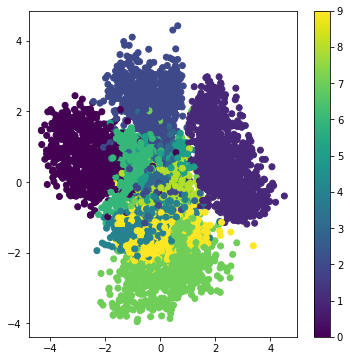

In [8]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean) # 查看z均值

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

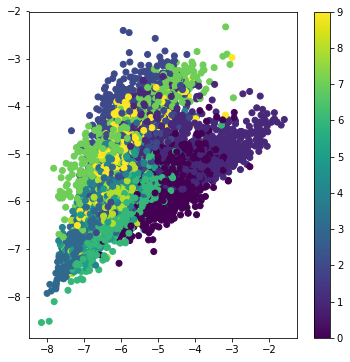

In [9]:
# build a model to project inputs on the latent space
encoder = Model(x, z_log_var) ## 查看方差

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

## 查看输出

In [10]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))  # 输入为隐变量
_h_decoded = decoder_h(decoder_input) # 这个层之前定义的, 复用
_x_decoded_mean = decoder_mean(_h_decoded) # 这个层之前定义的， 复用
generator = Model(decoder_input, _x_decoded_mean)

In [11]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


(28, 28)


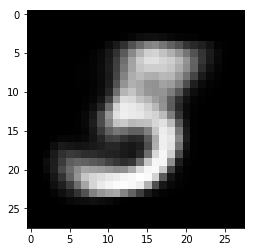

In [12]:
z_sample = np.array([[0.11428571, 0.5]])
one_digit = generator.predict(z_sample)
one_digit = one_digit.reshape((28,28))
print(one_digit.shape)
plt.imshow(one_digit, cmap='Greys_r')
plt.show()

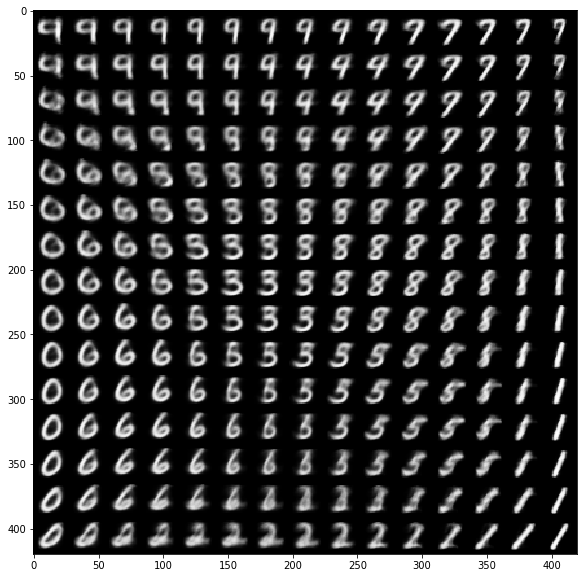

In [13]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [14]:
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [15]:
grid_x

array([-1.64485363e+00, -1.20404696e+00, -9.20822976e-01, -6.97141435e-01,
       -5.03965367e-01, -3.28072108e-01, -1.61844167e-01, -1.39145821e-16,
        1.61844167e-01,  3.28072108e-01,  5.03965367e-01,  6.97141435e-01,
        9.20822976e-01,  1.20404696e+00,  1.64485363e+00])

In [16]:
np.linspace(0.05, 0.95, n)

array([0.05      , 0.11428571, 0.17857143, 0.24285714, 0.30714286,
       0.37142857, 0.43571429, 0.5       , 0.56428571, 0.62857143,
       0.69285714, 0.75714286, 0.82142857, 0.88571429, 0.95      ])

# 参考资料

VAE:
https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
https://mp.weixin.qq.com/s/627RXH2VWN_DNuLuUIJS4A
https://blog.csdn.net/JackyTintin/article/details/53641885

https://arxiv.org/abs/1312.6114
https://arxiv.org/abs/1606.05908


CVAE:
